**<font size="5">Project 1</font>** <br> <br>
Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

To create a low risk portfolio, we first gather data on 100 stocks -- 10 stocks each across 10 industry sectors. Ultimately we will select one stock out of each sector, so that the volatility of the resulting portfolio is small. We will consider a portfolio where each stock has equal weight, along with one where the weights are optimized to further reduce the volatility. The underlying fact we are using in building our initial portfolio is that the smaller the correlation between random variables, the smaller the variance of a resulting portfolio (holding the variances of the individual random variables fixed).

We gather data on the performance of each stock from June 10 2019 to June 10 2024. We then test our portfolio(s) later on the past year (so as not to test the performance of the portfolio in the time range we used to create it):

In [ ]:
#yfinance issues, followed https://github.com/ranaroussi/yfinance/issues/2422#issuecomment-2840774505 to avoid

import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from curl_cffi import requests
import time

# Create session that impersonates Chrome --  doing this due to yfinance issues, followed https://github.com/ranaroussi/yfinance/issues/2422#issuecomment-2840774505 to avoid
session = requests.Session(impersonate="chrome")

# 10 industry sectors from GICS list and 10 tickers in each sector
industries = {
    "tech": ["AAPL", "MSFT", "GOOGL", "META", "ORCL", "ADBE", "NVDA", "CRM", "INTC", "AMD"],
    "healthcare": ["JNJ", "PFE", "MRK", "ABBV", "TMO", "UNH", "BMY", "AMGN", "LLY", "GILD"],
    "financial": ["JPM", "BAC", "WFC", "C", "GS", "MS", "AXP", "BK", "USB", "PNC"],
    "energy": ["XOM", "CVX", "COP", "PSX", "EOG", "VLO", "MPC", "SLB", "BKR", "HAL"],
    "consumer discretionary": ["TSLA", "AMZN", "HD", "MCD", "NKE", "LOW", "SBUX", "TJX", "GM", "F"],
    "industrial": ["HON", "GE", "UPS", "BA", "CAT", "MMM", "DE", "LMT", "UNP", "CSX"],
    "consumer staples": ["PG", "KO", "PEP", "WMT", "COST", "MO", "MDLZ", "CL", "KMB", "KR"],
    "utilities": ["NEE", "DUK", "SO", "AEP", "EXC", "D", "SRE", "PEG", "WEC", "ED"],
    "materials": ["LIN", "APD", "SHW", "ECL", "NEM", "FCX", "DD", "PPG", "VMC", "MLM"],
    "real estate": ["PLD", "AMT", "CCI", "EQIX", "PSA", "DLR", "SPG", "O", "VTR", "AVB"]
}


# flatten all tickers into one list
tickers = [ticker for industry in industries.values() for ticker in industry]
adj_close_data = {}

for ticker in tickers:
    try:
        print(f"Fetching: {ticker}")
        t = yf.Ticker(ticker, session=session)
        end = datetime(2024, 6, 10)  # 1 year ago
        start = datetime(2019, 6, 10) # 6 years ago
        # fetch data in that range
        hist = t.history(start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), interval="1d")["Close"]
        if not hist.empty:
            adj_close_data[ticker] = hist
        else:
            print(f"Empty or missing data for {ticker}")
    except Exception as e:
        print(f"Failed to fetch {ticker}: {e}")
    time.sleep(0.05)  # small delay to avoid rate limits, just in case

# create dataframe and drop NaN/invalid entries
data = pd.DataFrame(adj_close_data)
data = data.dropna(axis=1, how='all')
data = data.ffill().bfill()
data = data.dropna()
data = data[data > 0]

# get log returns
log_returns = np.log(data / data.shift(1)).dropna()

We look at a heatmap of the covariance matrix of the log returns:

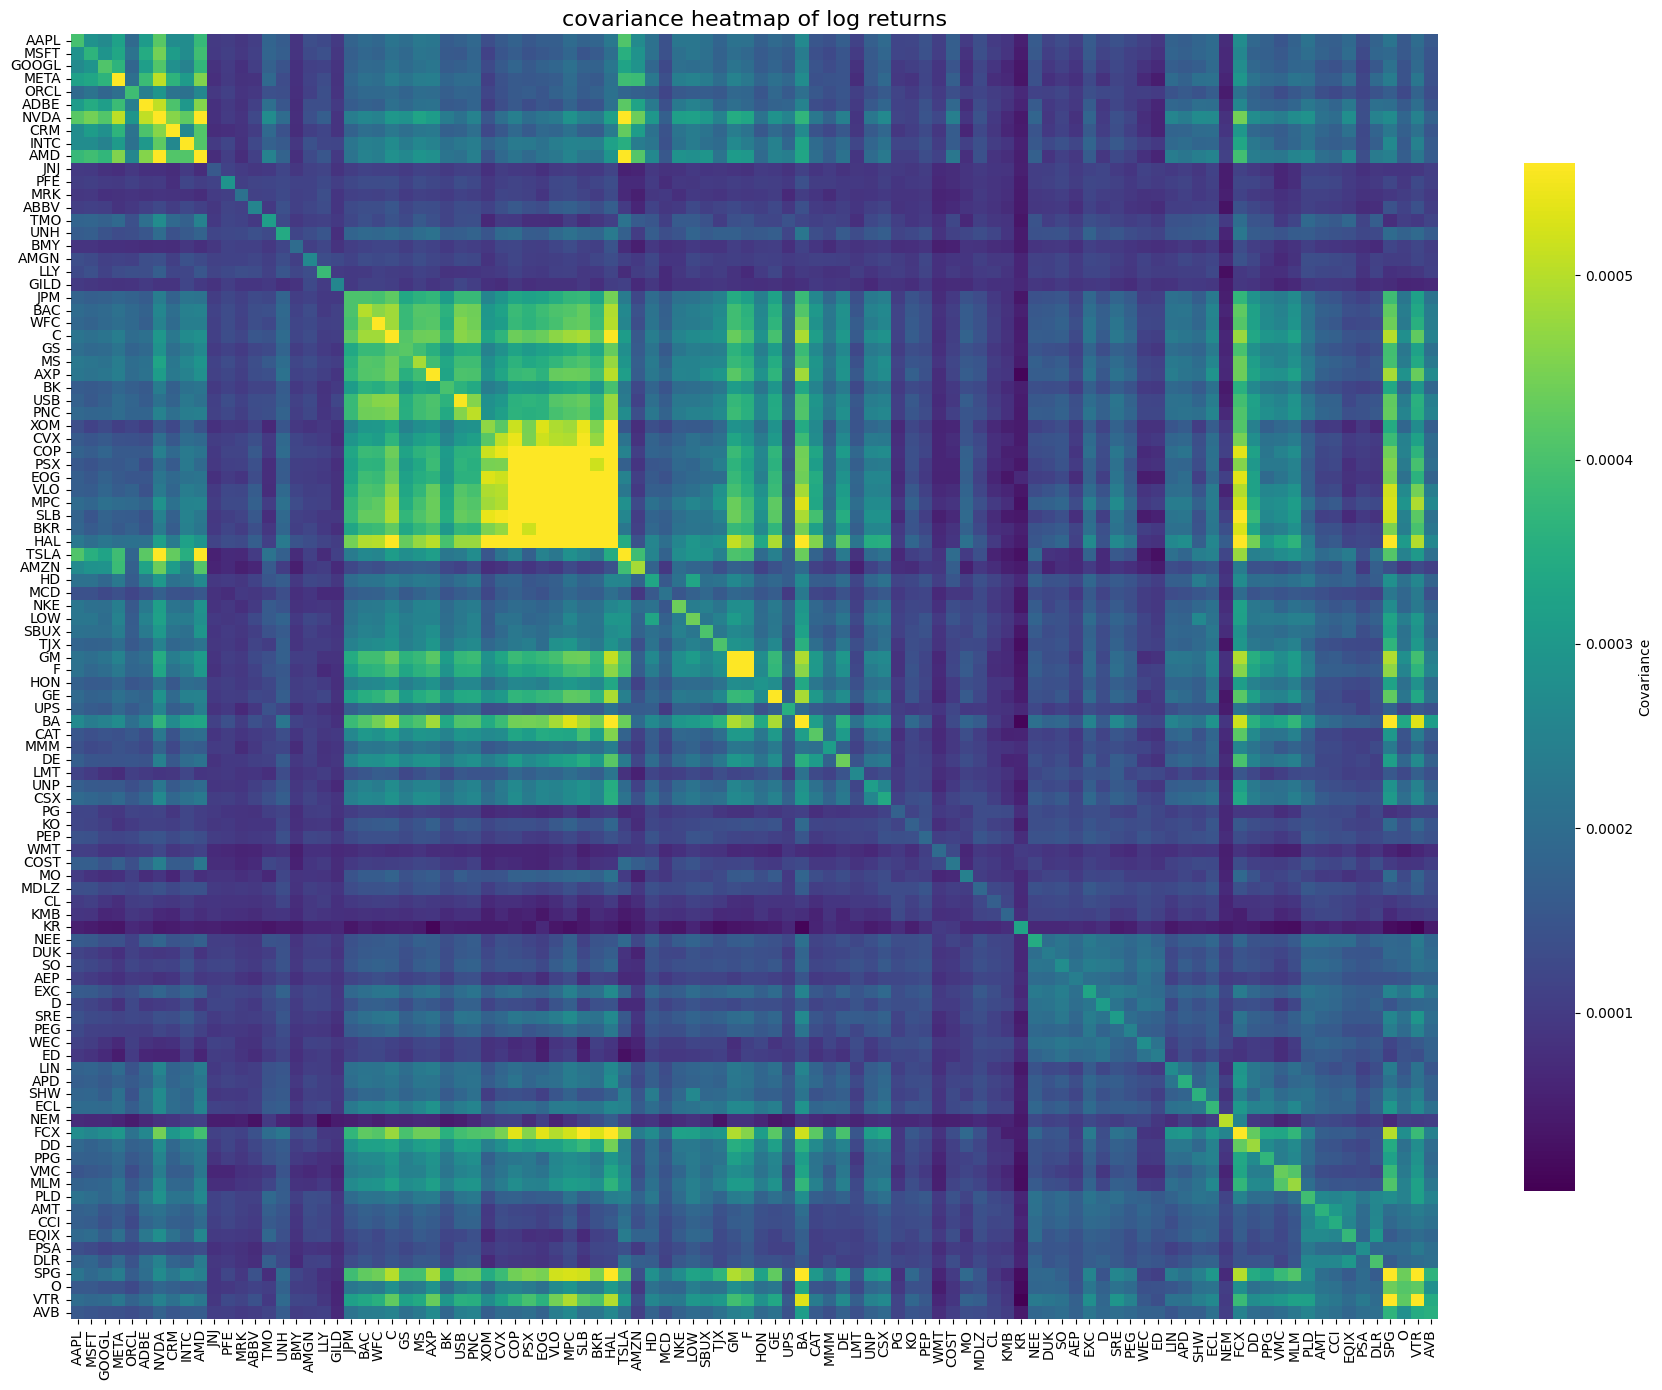

In [4]:
# compute the covariance matrix
cov_matrix = log_returns.cov()

# heatmap for the covariance matrix
plt.figure(figsize=(18, 14))
sns.heatmap(
    cov_matrix,
    cmap="viridis",
    xticklabels=True,
    yticklabels=True,
    cbar_kws={"shrink": 0.8, "label": "Covariance"},
    vmin=np.percentile(cov_matrix.values, 0.01),
    vmax=np.percentile(cov_matrix.values, 99)
)
plt.title("covariance heatmap of log returns", fontsize=16)
plt.tight_layout()
plt.show()

Let's also list the volatilities of each stock in this time period:

In [ ]:
# compute volatility (standard deviation of log returns)
volatility = log_returns.std()

# group tickers by sector and sort within each group
vol_by_sector = {}

for sector, sector_tickers in industries.items():
    valid_tickers = [ticker for ticker in sector_tickers if ticker in volatility]
    sector_vols = volatility[valid_tickers].sort_values(ascending=False)
    vol_by_sector[sector] = sector_vols

for sector, series in vol_by_sector.items():
    print(f"\n -- {sector} (sorted by volatility):")
    print(series.to_string())


 -- tech (sorted by volatility):
AMD      0.032846
NVDA     0.032716
META     0.028329
INTC     0.025095
CRM      0.024767
ADBE     0.023840
GOOGL    0.020175
AAPL     0.019913
ORCL     0.019703
MSFT     0.019100

 -- healthcare (sorted by volatility):
LLY     0.019541
UNH     0.018509
TMO     0.017700
PFE     0.017098
AMGN    0.016247
GILD    0.016113
ABBV    0.016067
MRK     0.014527
BMY     0.014103
JNJ     0.012533

 -- financial (sorted by volatility):
C      0.024433
WFC    0.024048
AXP    0.023685
USB    0.023574
PNC    0.022480
BAC    0.022354
MS     0.022036
GS     0.020382
JPM    0.020059
BK     0.019942

 -- energy (sorted by volatility):
HAL    0.036317
SLB    0.031516
EOG    0.030552
VLO    0.030212
MPC    0.030148
BKR    0.028252
COP    0.028156
PSX    0.026665
CVX    0.022489
XOM    0.021616

 -- consumer discretionary (sorted by volatility):
TSLA    0.040888
F       0.027171
GM      0.026599
AMZN    0.022041
LOW     0.020921
NKE     0.020872
TJX     0.020082
SBUX    0.

We now find the selection of 10 stocks, 1 from each sector, that minimizes the maximum covariance among them, after filtering out high-volatility stocks:

In [6]:
from itertools import product

# filter each sector to low-volatility tickers
low_volatility_tickers = volatility[volatility <= 0.022].index

sector_candidates = {
    sector: [ticker for ticker in tickers if ticker in low_volatility_tickers]
    for sector, tickers in industries.items()
}

# create all combinations
sector_names = list(sector_candidates.keys())
combinations = list(product(*[sector_candidates[s] for s in sector_names]))

# find the combination minimizing max covariance
def max_cov(tickers):
    cov = log_returns[list(tickers)].cov().values
    np.fill_diagonal(cov, -np.inf)
    return np.max(cov)

best_combo = None
min_max_cov = np.inf

for combo in combinations:
    curr_max = max_cov(combo)
    if curr_max < min_max_cov:
        min_max_cov = curr_max
        best_combo = combo

best_combo_named = dict(zip(sector_names, best_combo))
print("Best 10-tuple (one per sector) with min-max covariance:")
print(best_combo_named)
print(f"Minimum of maximum pairwise covariance: {min_max_cov:.6f}")

Best 10-tuple (one per sector) with min-max covariance:
{'tech': 'AAPL', 'healthcare': 'JNJ', 'financial': 'BK', 'energy': 'XOM', 'consumer discretionary': 'HD', 'industrial': 'HON', 'consumer staples': 'PG', 'utilities': 'NEE', 'materials': 'LIN', 'real estate': 'PLD'}
Minimum of maximum pairwise covariance: 0.000237


The selected tickers are [AAPL, JNJ, BK, XOM, HD, HON, PG, NEE, LIN, PLD]. We build a uniformly weighted portfolio with these and look at the portfolio's performance over the last year:

Let's look at its log and ordinary returns over the last year:

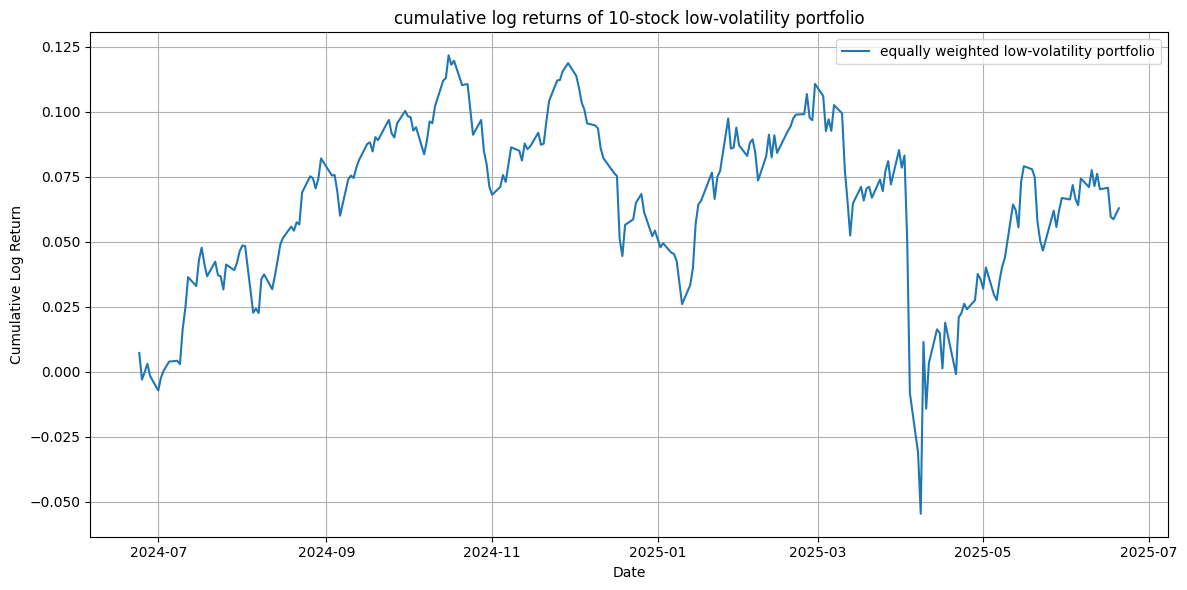

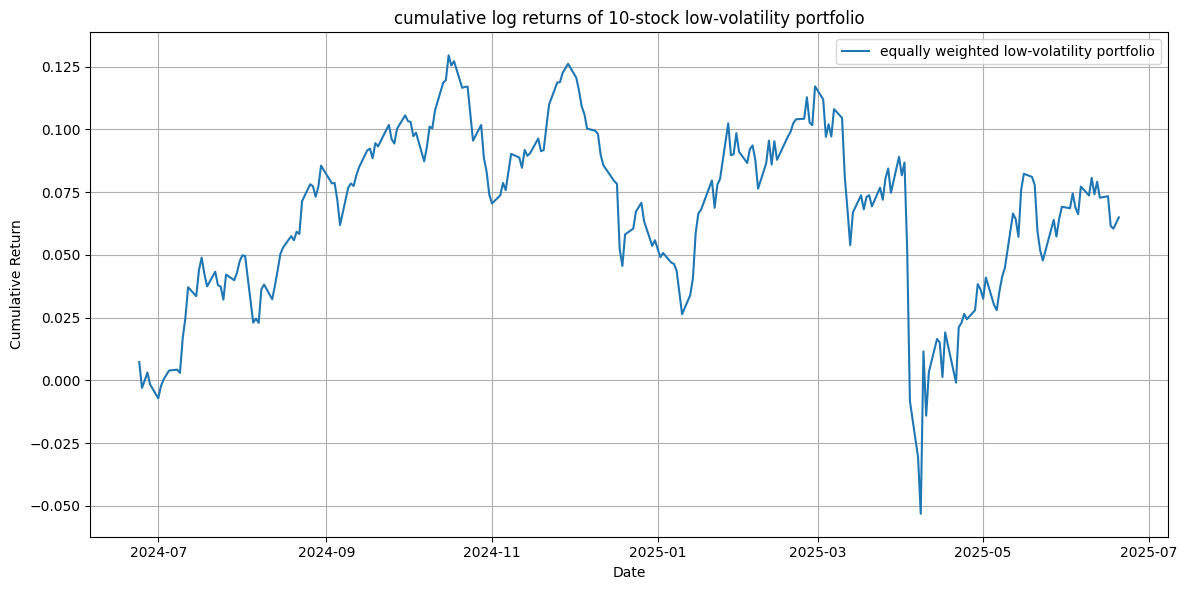

In [12]:
# the chosen 10-tuple of tickers
selected_tickers = ["AAPL", "JNJ", "BK", "XOM", "HD", "HON", "PG", "NEE", "LIN", "PLD"]

# download individual stock data
price_data = pd.DataFrame()

for ticker in selected_tickers:
    t = yf.Ticker(ticker, session=session)
    hist = t.history(period="1y", interval="1d")["Close"]
    price_data[ticker] = hist

# clean the data
price_data = price_data.ffill().bfill().dropna()
price_data = price_data[price_data > 0]

# get log returns
log_returns = np.log(price_data / price_data.shift(1)).dropna()

# set uniform weights
weights = np.full(len(selected_tickers), 1 / len(selected_tickers))

# portfolio log returns
portfolio_log_returns = log_returns.dot(weights)

# cumulative log return
cumulative_log_returns = portfolio_log_returns.cumsum()





# now plot the log returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_log_returns, label="equally weighted low-volatility portfolio")
plt.title("cumulative log returns of 10-stock low-volatility portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# convert to ordinary returns and cumulative ordinary return
portfolio_returns = np.exp(portfolio_log_returns) - 1
portfolio_value = (1 + portfolio_returns).cumprod() * initial_value

# compute cumulative ordinary returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="equally weighted low-volatility portfolio")
plt.title("cumulative log returns of 10-stock low-volatility portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


We compute the volatility:

In [8]:
daily_volatility = portfolio_log_returns.std()
annualized_volatility = daily_volatility * np.sqrt(252)

print(f"Daily Volatility: {daily_volatility:.4%}")
print(f"Annualized Volatility: {annualized_volatility:.4%}")

Daily Volatility: 1.0051%
Annualized Volatility: 15.9559%


The nearly 16% annualized volatility calls into question the "low volatility" label we are using, but given the dramatic market movement around Liberation Day, and the events surrounding it, this seems fairly low. 

Now, by contrast, the first highly volatile stock that one thinks of is TSLA. We plot its performance against the above portfolio:

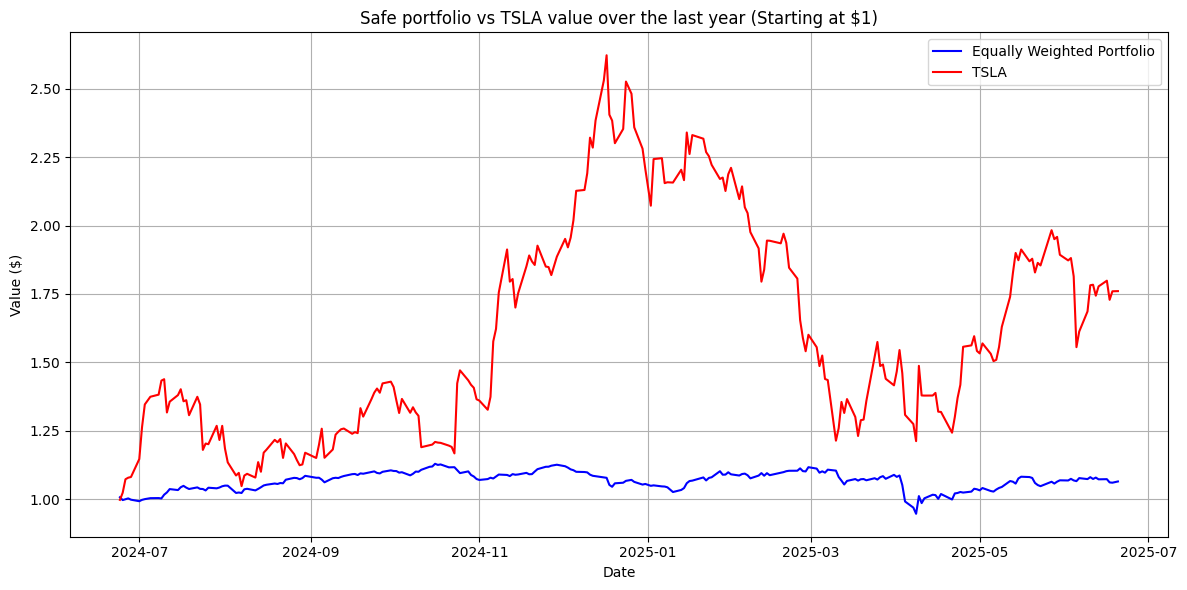

In [ ]:
# Download TSLA data

initial_value = 1

tsla_ticker = yf.Ticker("TSLA", session=session)
tsla_hist = tsla_ticker.history(period="1y", interval="1d")["Close"]
tsla_hist = tsla_hist.ffill().bfill().dropna()
tsla_hist = tsla_hist[tsla_hist > 0]

tsla_log_returns = np.log(tsla_hist / tsla_hist.shift(1)).dropna()
tsla_returns = np.exp(tsla_log_returns) - 1
tsla_value = (1 + tsla_returns).cumprod() * initial_value

# Align TSLA and portfolio on the same dates
common_dates = portfolio_value.index.intersection(tsla_value.index)
portfolio_value_aligned = portfolio_value.loc[common_dates]
tsla_value_aligned = tsla_value.loc[common_dates]

# Plot both
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_aligned, label="Equally Weighted Portfolio", color="blue")
plt.plot(tsla_value_aligned, label="TSLA", color="red")
plt.title("Safe portfolio vs TSLA value over the last year (Starting at $1)")
plt.xlabel("Date")
plt.ylabel("Value in USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TSLA's volatility:

In [14]:
daily_volatility_TSLA = tsla_log_returns.std()
annualized_volatility_TSLA = daily_volatility_TSLA * np.sqrt(252)

print(f"Daily Volatility: {daily_volatility_TSLA:.4%}")
print(f"Annualized Volatility: {annualized_volatility_TSLA:.4%}")

Daily Volatility: 4.6299%
Annualized Volatility: 73.4975%


Let's see how these two portfolios performed over the past six years:

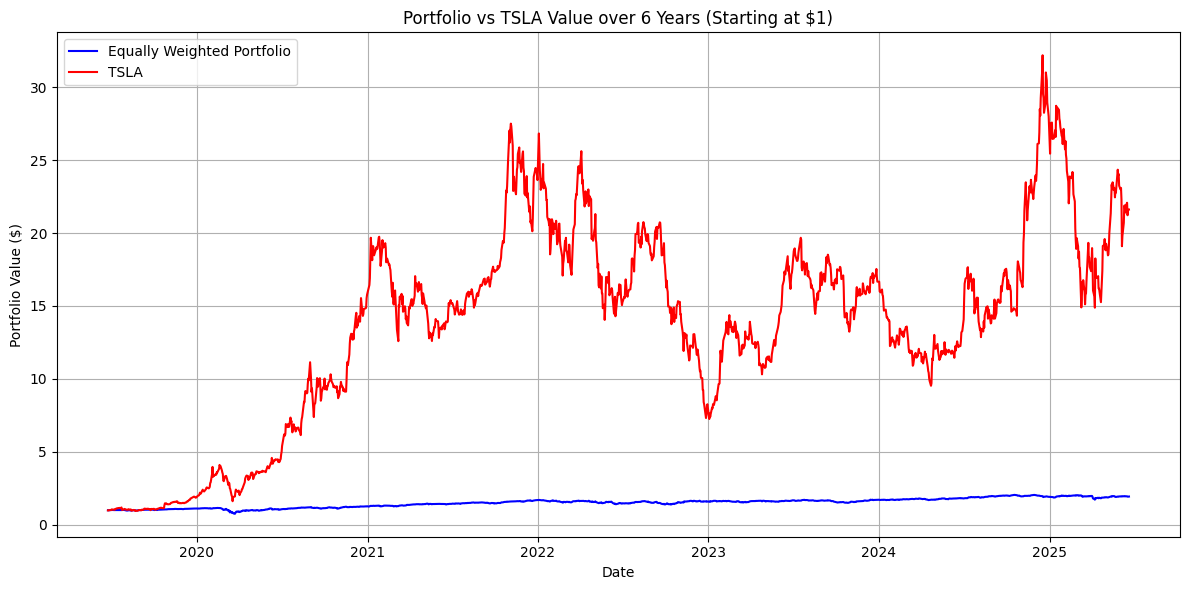

In [ ]:
end_date = datetime.today()
start_date = end_date - timedelta(days=6 * 365)
price_data_6y = pd.DataFrame()

# download 6-year daily data for each ticker
for ticker in selected_tickers:
    t = yf.Ticker(ticker, session=session)
    hist = t.history(
        start=start_date.strftime("%Y-%m-%d"),
        end=end_date.strftime("%Y-%m-%d"),
        interval="1d"
    )["Close"]
    price_data_6y[ticker] = hist

# clean data
price_data_6y = price_data_6y.ffill().bfill().dropna()
price_data_6y = price_data_6y[price_data_6y > 0]

# Log returns and portfolio construction
log_returns_6y = np.log(price_data_6y / price_data_6y.shift(1)).dropna()
weights_6y = np.full(len(selected_tickers), 1 / len(selected_tickers))
portfolio_log_returns_6y = log_returns_6y.dot(weights_6y)
portfolio_returns_6y = np.exp(portfolio_log_returns_6y) - 1

initial_value = 1
portfolio_value_6y = (1 + portfolio_returns_6y).cumprod() * initial_value

# TSLA over same 6-year period
tsla = yf.Ticker("TSLA", session=session)
tsla_hist_6y = tsla.history(
    start=start_date.strftime("%Y-%m-%d"),
    end=end_date.strftime("%Y-%m-%d"),
    interval="1d"
)["Close"]

tsla_hist_6y = tsla_hist_6y.ffill().bfill().dropna()
tsla_hist_6y = tsla_hist_6y[tsla_hist_6y > 0]
tsla_log_returns_6y = np.log(tsla_hist_6y / tsla_hist_6y.shift(1)).dropna()
tsla_returns_6y = np.exp(tsla_log_returns_6y) - 1
tsla_value_6y = (1 + tsla_returns_6y).cumprod() * initial_value

# align dates
common_dates_6y = portfolio_value_6y.index.intersection(tsla_value_6y.index)
portfolio_value_6y = portfolio_value_6y.loc[common_dates_6y]
tsla_value_6y = tsla_value_6y.loc[common_dates_6y]

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_6y, label="Equally Weighted Portfolio", color="blue")
plt.plot(tsla_value_6y, label="TSLA", color="red")
plt.title("Portfolio vs TSLA Value over 6 Years (Starting at $1)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value in USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now, for our "safe" portfolio, we will optimize the weights as in class, to make its volatility even smaller. We again use 2019-2024 data to do so:

In [ ]:
from scipy.optimize import minimize

price_data = pd.DataFrame()
for ticker in selected_tickers:
    t = yf.Ticker(ticker, session=session)
    end = datetime(2024, 6, 10) # 1 year ago
    start = datetime(2019, 6, 10) # 6 years ago
    hist = t.history(start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), interval="1d")["Close"]
    price_data[ticker] = hist

# clean data
price_data.dropna(inplace=True)

# calculate log daily returns
daily_returns = np.log(price_data / price_data.shift(1)).dropna()

# covariance matrix of returns, annualized
covariance_matrix = 252 * daily_returns.cov()

initial_weights = np.array([1 / 10] * 10)

# constraints
constraints = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'ineq', 'fun': lambda w: np.min(w) - 0.10},
    {'type': 'ineq', 'fun': lambda w: 0.35 - np.max(w)},
)

# as in class, objective function: minimize portfolio volatility
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix.values, weights)))

# now optimize
result = minimize(portfolio_volatility, initial_weights, constraints=constraints, bounds=[(0.05, 0.3)] * 10)

optimal_weights = result.x
print("\nOptimal asset weights to minimize volatility:")
for ticker, weight in zip(selected_tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

print(f"\nThe optimal portfolio volatility subject to the constraints is {result.fun:.4f}")

weights = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
uniform_result = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix.values, weights)))

print(f"\nPortfolio volatility with uniform weights is {uniform_result}")



Optimal asset weights to minimize volatility:
AAPL: Weight = 0.0500
JNJ: Weight = 0.3000
BK: Weight = 0.0500
XOM: Weight = 0.0548
HD: Weight = 0.0500
HON: Weight = 0.0500
PG: Weight = 0.2952
NEE: Weight = 0.0500
LIN: Weight = 0.0500
PLD: Weight = 0.0500

The optimal portfolio volatility subject to the constraints is 0.1803

Portfolio volatility with uniform weights is 0.20417203338476728


The optimization successfully gives us a noticeably smaller volatility. Note that this is volatility on the 2019-2024 range, which is the range on which we are building our portfolio. Now we see how this new rebalanced portfolio performs on the past year.

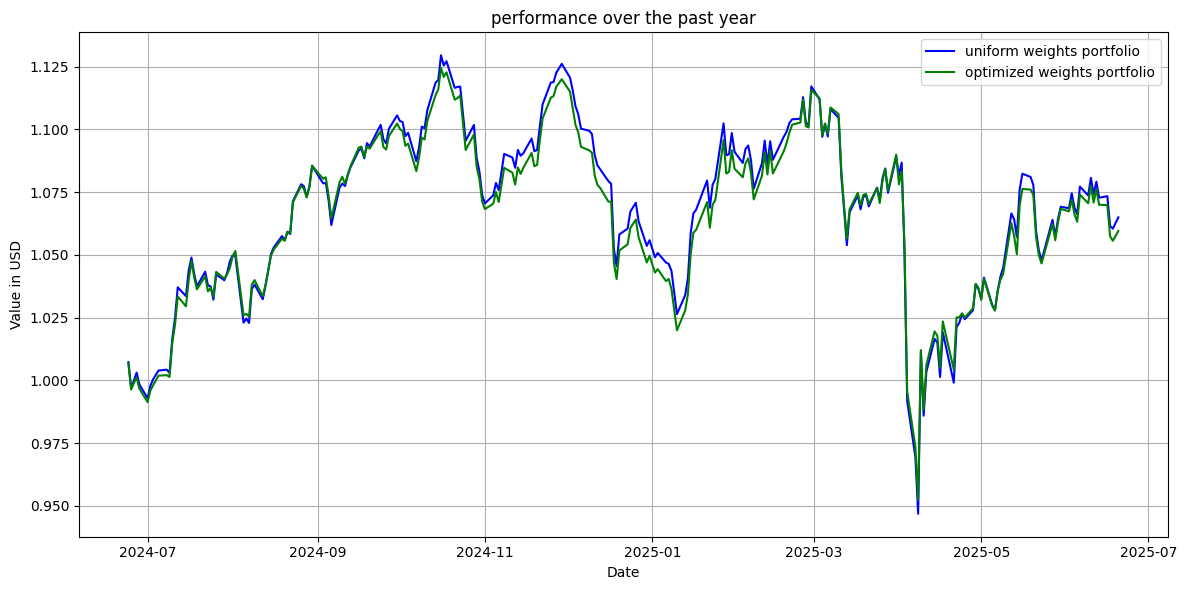

In [18]:
initial_value = 1.0

weights = np.array([0.09000302, 0.15111077, 0.09005269, 0.09001429, 0.0900033,  0.09000302, 0.1286761,  0.09006317, 0.09007058, 0.09000306])
portfolio2_log_returns = log_returns.dot(weights)
portfolio2_returns = np.exp(portfolio2_log_returns) - 1
portfolio2_value = (1 + portfolio2_returns).cumprod() * initial_value


# align all three just in case
common_dates = portfolio_value.index.intersection(tsla_value.index).intersection(portfolio2_value.index)
portfolio_value = portfolio_value.loc[common_dates]
portfolio2_value = portfolio2_value.loc[common_dates]
tsla_value = tsla_value.loc[common_dates]

# plot only the safe portfolios to see what's going on (TSLA would mess up the scale)
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label="uniform weights portfolio", color="blue")
plt.plot(portfolio2_value, label="optimized weights portfolio", color="green")
#plt.plot(tsla_value, label="TSLA", color="red")
plt.title("performance over the past year")
plt.xlabel("Date")
plt.ylabel("Value in USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Overall the portfolios seem to be quite similar in performance.

Now let's compare everything to a risk-free portfolio:

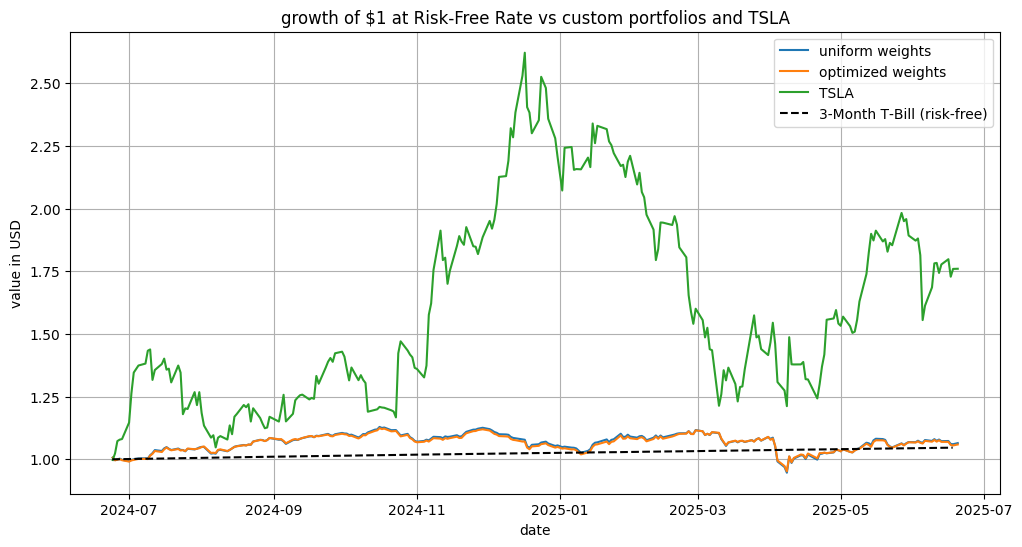

In [23]:
# risk free rate $1 growing

from pandas_datareader import data as pdr

end = datetime.today()
start = end - timedelta(days=365)

# get 3-month treasury rates (percent per annum)
risk_free = pdr.DataReader('DGS3MO', 'fred', start, end).dropna()

# Convert to daily decimals
risk_free['rf_daily'] = risk_free['DGS3MO'] / 100 / 252

# calculate cumulative growth of $1
risk_free['rf_value'] = (1 + risk_free['rf_daily']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(portfolio_value, label="uniform weights")
plt.plot(portfolio2_value, label="optimized weights")
plt.plot(tsla_value, label = "TSLA")
plt.plot(risk_free['rf_value'], label="3‑Month T‑Bill (risk-free)", linestyle='--', color='black')
plt.title("growth of $1 at Risk-Free Rate vs custom portfolios and TSLA")
plt.xlabel("date")
plt.ylabel("value in USD")
plt.legend()
plt.grid(True)
plt.show()


**<font size="5">Project 2</font>** <br> <br>
In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed. Investigate if the log returns of stocks or indexes of your choosing are normally distributed.

We consider the low volatility portfolio with optimized weights from the previous project, and look at a one-year-long sliding window of its performance over the past six years. On this sliding window we perform the Shapiro-Wilk test for normality and plot the corresponding p-values:

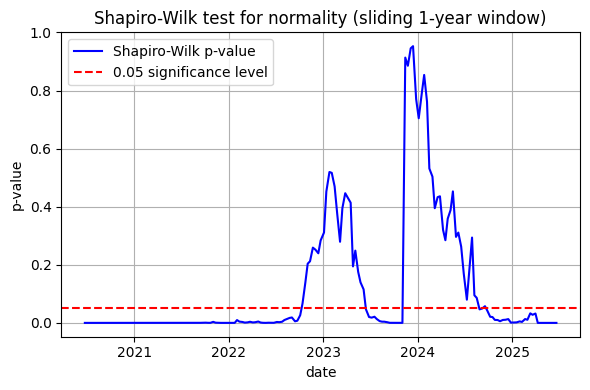

In [56]:
from scipy.stats import shapiro

window_size = 252  # 1 trading year
p_values = []

# low volatility, non-uniform, portfolio in portfolio_log_returns

for i in range(window_size, len(portfolio_log_returns_6y),7):
    window_data = portfolio_log_returns_6y.iloc[i - window_size:i]
    stat, p = shapiro(window_data)
    p_values.append((portfolio_log_returns_6y.index[i], p))

#print([float(p[1]) for p in p_values]) # p-values for each window

p_df = pd.DataFrame(p_values, columns=["Date", "P_Value"]).set_index("Date")

# Plot
plt.figure(figsize=(6,4))
plt.plot(p_df.index, p_df["P_Value"], label="Shapiro-Wilk p-value", color="blue")
plt.axhline(0.05, color="red", linestyle="--", label="0.05 significance level")
plt.title("Shapiro-Wilk test for normality (sliding 1-year window)")
plt.xlabel("date")
plt.ylabel("p-value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We see that, most of the time, the p-value is below the 0.05 threshold (even much lower), during which periods we would reject the null-hypothesis of normality of log returns. There are the two apparent spikes in windows terminating in early-mid 2023 and 2024 where we would not reject the null-hypothesis (and could, from there, accept the alternative that the portfolio returns are lognormal).

Let us look now at TSLA, our "high volatility portfolio", in the same way:

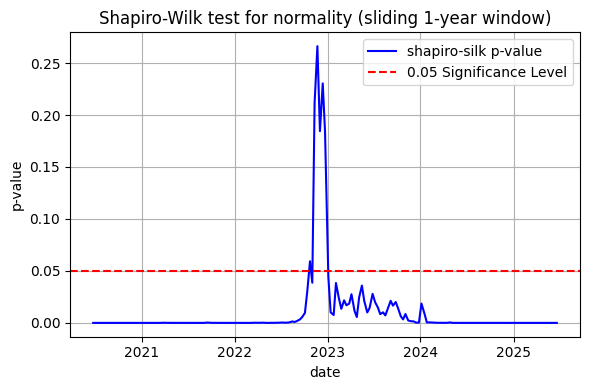

In [57]:
# tsla

p_values = []


for i in range(window_size, len(tsla_log_returns_6y),7):
    window_data = tsla_log_returns_6y.iloc[i - window_size:i]
    stat, p = shapiro(window_data)
    p_values.append((tsla_log_returns_6y.index[i], p))

p_df = pd.DataFrame(p_values, columns=["Date", "P_Value"]).set_index("Date")

plt.figure(figsize=(6,4))
plt.plot(p_df.index, p_df["P_Value"], label="shapiro-silk p-value", color="blue")
plt.axhline(0.05, color="red", linestyle="--", label="0.05 Significance Level")
plt.title("Shapiro-Wilk test for normality (sliding 1-year window)")
plt.xlabel("date")
plt.ylabel("p-value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Here, by contrast, there is one relatively short range of window termination dates where we do not have enough evidence to reject the null hypothesis of normality. Otherwise, the p-value is mostly extremely small, and we reject the null hypothesis of normality.

Let us now take a specific one-year window for the optimized weights low-volatility portfolio where the p-value is below, but not many orders of magnitude below, the threshold of 0.05, and see if the threshold is surpassed if we remove some outlier data. We take the window terminating on February 1 2025:

In [58]:
# select a specific window for first portfolio, namely one year window terminating on feb 1 2025, and test for normality

portfolio_log_returns_6y.index = pd.to_datetime(portfolio_log_returns_6y.index).tz_localize(None)
end_date = pd.Timestamp("2025-02-01").tz_localize(None)

# get 1-year (252-day) window ending on that date
window_data = portfolio_log_returns_6y.loc[:end_date].iloc[-252:]

stat, p = shapiro(window_data)

print(f"Shapiro-Wilk p-value for window ending {end_date.date()}: {p:.6f}")

Shapiro-Wilk p-value for window ending 2025-02-01: 0.008064


We make a QQ plot (quantile-quantile plot) to visually compare the empirical distribution we get in this window to a normal distribution:

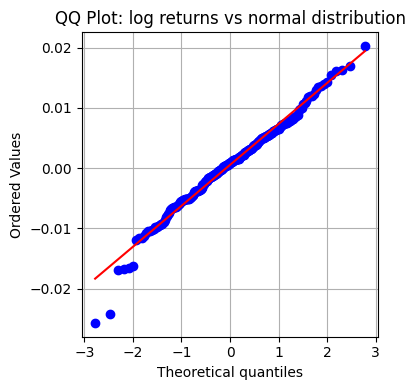

In [60]:
fig, ax = plt.subplots(figsize=(4,4))
stats.probplot(window_data, dist="norm", plot=ax)

ax.set_title("QQ Plot: log returns vs normal distribution")
ax.grid(True)
plt.tight_layout()
plt.show()

There are clearly some outliers. So let us trim our data by removing everything below the 1st quantile, and everything above the 99th, and look at the QQ plot again:

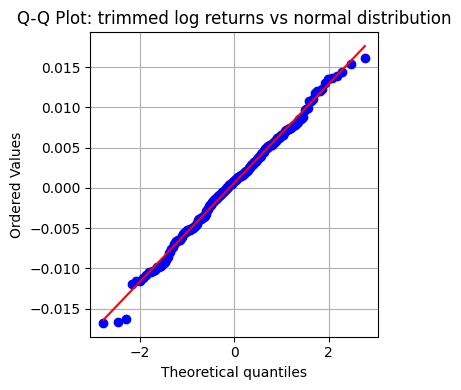

In [61]:
# trim data and replot

lower = window_data.quantile(0.01)
upper = window_data.quantile(0.99)

filtered_data = window_data[(window_data >= lower) & (window_data <= upper)]

fig, ax = plt.subplots(figsize=(4,4))
stats.probplot(filtered_data, dist="norm", plot=ax)

ax.set_title("Q-Q Plot: trimmed log returns vs normal distribution")
ax.grid(True)
plt.tight_layout()
plt.show()

This looks better, though there are some outliers again, albeit less extreme. Different trimmings seem to always result in the presence of some outliers at the extreme ends. In any case, this trimming now passes the Shapiro-Wilk test for normality:

In [62]:
# Run Shapiro-Wilk test
stat, p = shapiro(filtered_data)

print(f"Shapiro-Wilk p-value for window ending {end_date.date()}: {p:.6f}")

Shapiro-Wilk p-value for window ending 2025-02-01: 0.607725


The p-value is above the threshold of 0.05 and we do not reject the null hypothesis of normality.

Now let's see the one-year sliding windows over the past six years for each of the ten individual stocks comprising our portfolio, with their associated p-values in the Shapiro-Wilk test:

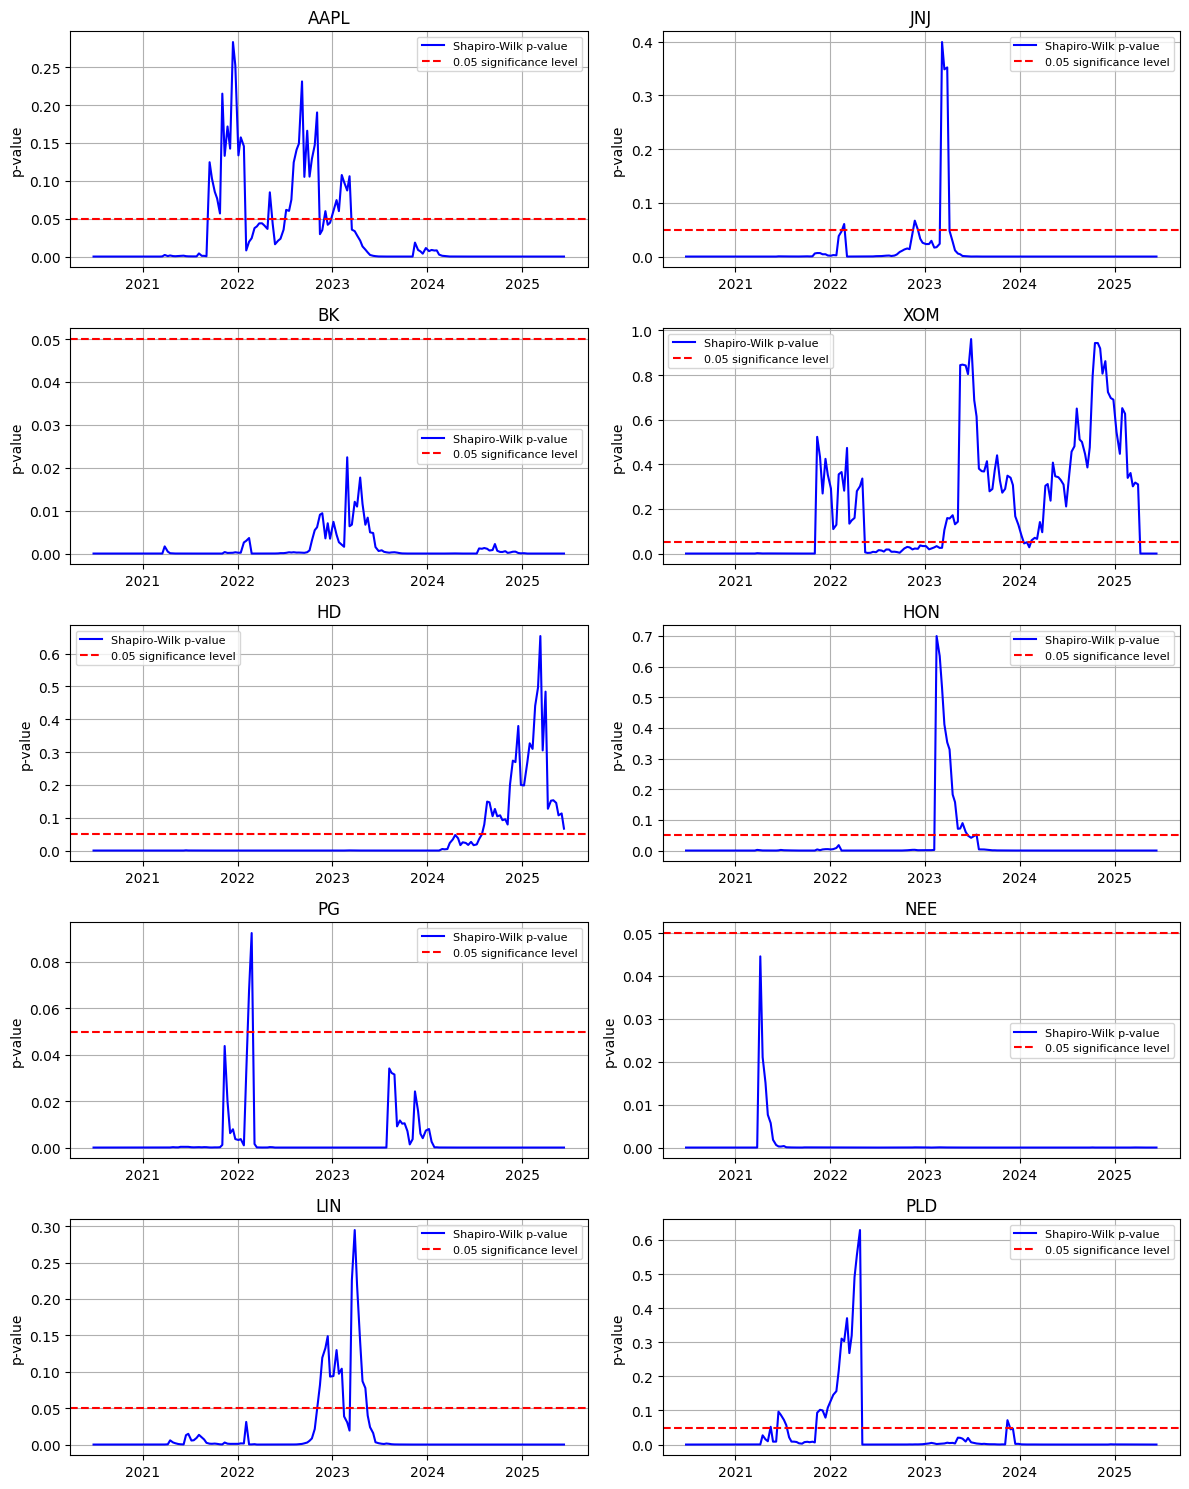

In [63]:
# now each of the ten stocks individually

# recall for convenience here our individual tickers
selected_tickers = ["AAPL", "JNJ", "BK", "XOM", "HD", "HON", "PG", "NEE", "LIN", "PLD"]
window_size = 252
step = 7
end = datetime.today()
start = end - timedelta(days=6 * 365)

# set up subplot grid: 5 rows x 2 columns
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
axs = axs.flatten()

for idx, ticker in enumerate(selected_tickers):
    #print(f"Processing: {ticker}")
    ax = axs[idx]

    t = yf.Ticker(ticker, session=session)
    hist = t.history(start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), interval="1d")["Close"]
    hist = hist.ffill().bfill().dropna()
    hist = hist[hist > 0]

    log_returns = np.log(hist / hist.shift(1)).dropna()

    # Shapiro-Wilk test in sliding window
    p_values = []
    for i in range(window_size, len(log_returns), step):
        window_data = log_returns.iloc[i - window_size:i]
        stat, p = shapiro(window_data)
        p_values.append((log_returns.index[i], float(p)))

    p_df = pd.DataFrame(p_values, columns=["date", "P_Value"]).set_index("date")
    ax.plot(p_df.index, p_df["P_Value"], label="Shapiro-Wilk p-value", color="blue")
    ax.axhline(0.05, color="red", linestyle="--", label="0.05 significance level")
    ax.set_title(f"{ticker}")
    #ax.set_xlabel("Date")
    ax.set_ylabel("p-value")
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


To explore further, let's perform the Shapiro-Wilk test on a sliding window again, but now we set the window size to 30 trading days (6 weeks):

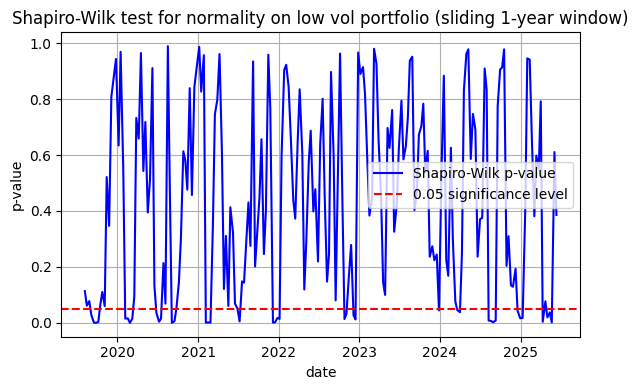

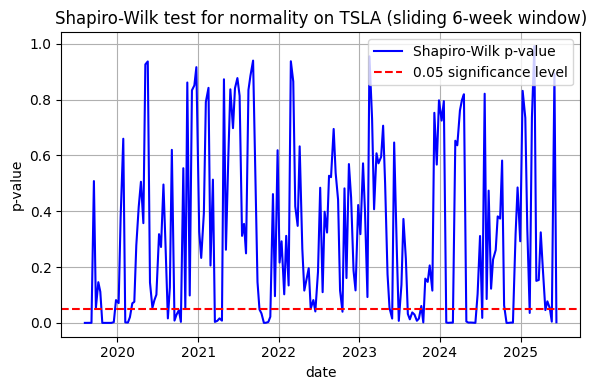

In [ ]:
# 6-week sliding window
window_size = 30  # 6 weeks
step = 7  # 1-week stride

# low volatility portfolio

p_values = []

for i in range(window_size, len(portfolio_log_returns_6y), step):
    window_data = portfolio_log_returns_6y.iloc[i - window_size:i]
    stat, p = shapiro(window_data)
    p_values.append((portfolio_log_returns_6y.index[i], p))

p_df = pd.DataFrame(p_values, columns=["Date", "P_Value"]).set_index("Date")

# Plot
plt.figure(figsize=(6,4))
plt.plot(p_df.index, p_df["P_Value"], label="Shapiro-Wilk p-value", color="blue")
plt.axhline(0.05, color="red", linestyle="--", label="0.05 significance level")
plt.title("Shapiro-Wilk test for normality on low vol portfolio (sliding 6-week window)")
plt.xlabel("date")
plt.ylabel("p-value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# tsla

p_values = []

for i in range(window_size, len(tsla_log_returns_6y), step):
    window_data = tsla_log_returns_6y.iloc[i - window_size:i]
    stat, p = shapiro(window_data)
    p_values.append((tsla_log_returns_6y.index[i], p))

p_df = pd.DataFrame(p_values, columns=["Date", "P_Value"]).set_index("Date")

plt.figure(figsize=(6,4))
plt.plot(p_df.index, p_df["P_Value"], label="Shapiro-Wilk p-value", color="blue")
plt.axhline(0.05, color="red", linestyle="--", label="0.05 significance level")
plt.title("Shapiro-Wilk test for normality on TSLA (sliding 6-week window)")
plt.xlabel("date")
plt.ylabel("p-value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The first thing we notice is the much more extreme, but also periodic, behavior of the p-value. Now, the majority of the time we would not reject the null hypothesis. Let's look at the individual stocks from the low volatility portfolio with this smaller window as well: 

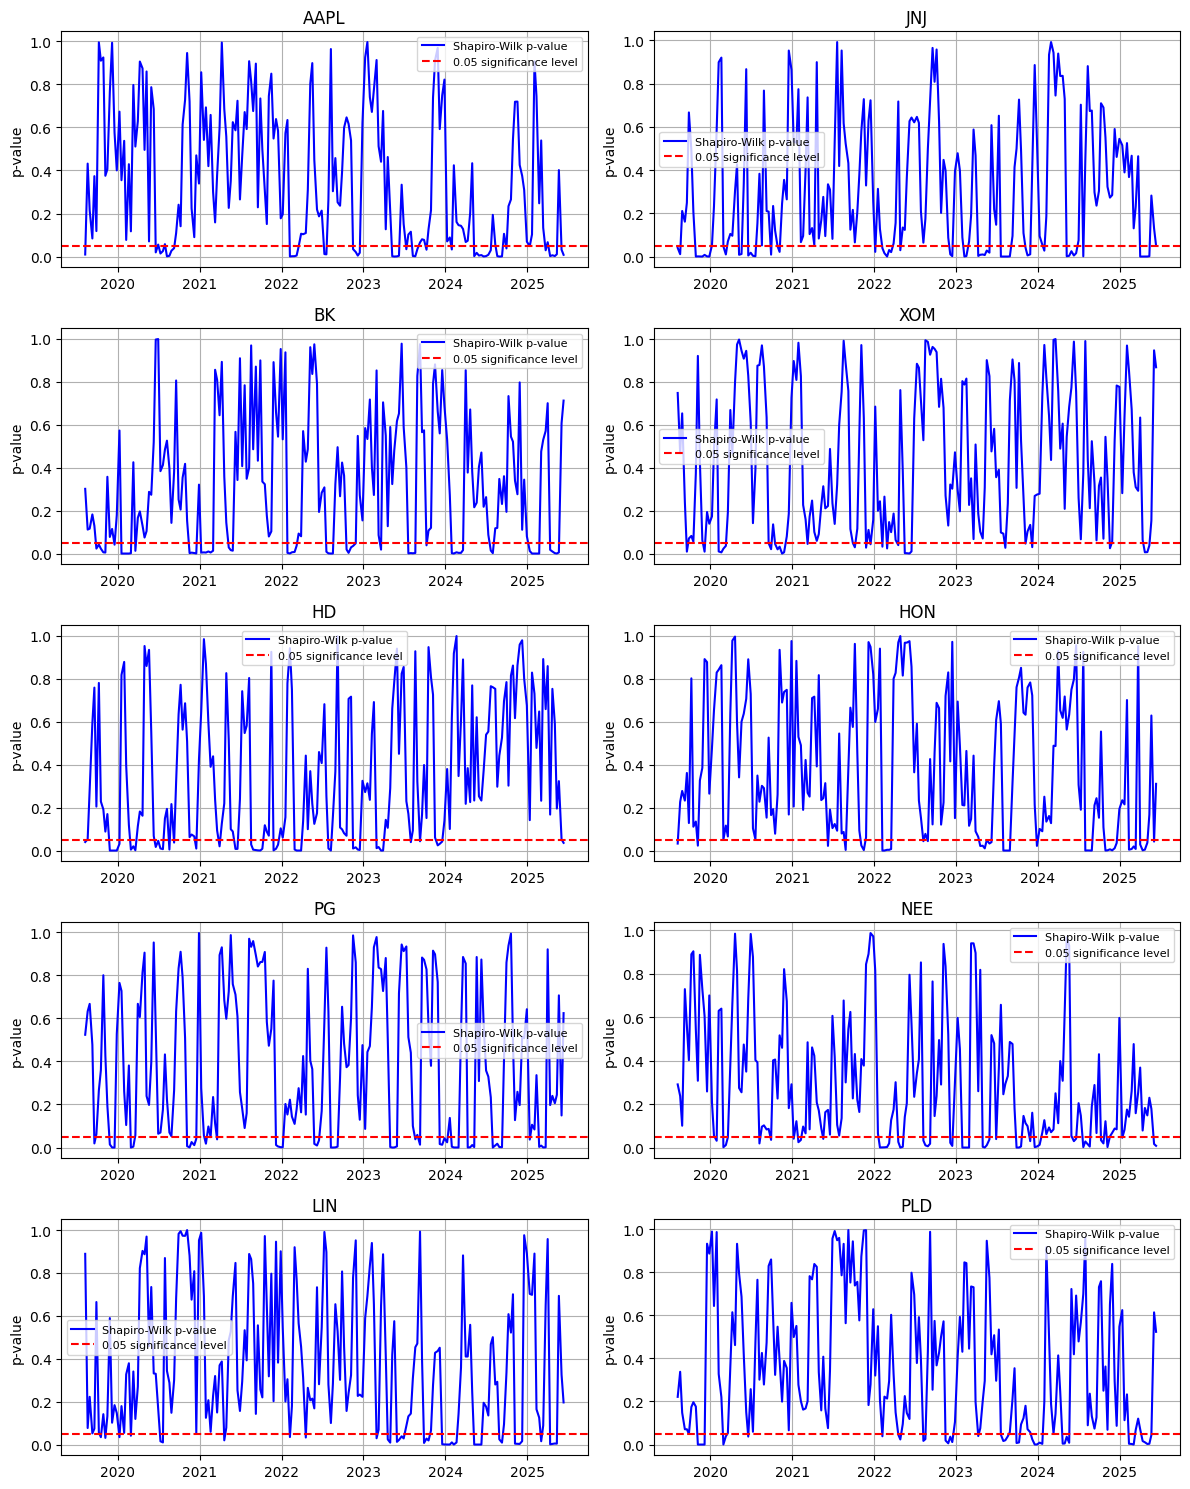

In [66]:
# now each of the ten stocks individually, 6-week sliding window

window_size = 30

# set up subplot grid: 5 rows x 2 columns
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
axs = axs.flatten()

for idx, ticker in enumerate(selected_tickers):
    #print(f"Processing: {ticker}")
    ax = axs[idx]

    t = yf.Ticker(ticker, session=session)
    hist = t.history(start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), interval="1d")["Close"]
    hist = hist.ffill().bfill().dropna()
    hist = hist[hist > 0]

    log_returns = np.log(hist / hist.shift(1)).dropna()

    # Shapiro-Wilk test in sliding window
    p_values = []
    for i in range(window_size, len(log_returns), step):
        window_data = log_returns.iloc[i - window_size:i]
        stat, p = shapiro(window_data)
        p_values.append((log_returns.index[i], float(p)))

    p_df = pd.DataFrame(p_values, columns=["Date", "P_Value"]).set_index("Date")
    ax.plot(p_df.index, p_df["P_Value"], label="Shapiro-Wilk p-value", color="blue")
    ax.axhline(0.05, color="red", linestyle="--", label="0.05 significance level")
    ax.set_title(f"{ticker}")
    #ax.set_xlabel("Date")
    ax.set_ylabel("p-value")
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


Again the p-value behavior is more extreme, and somewhat periodic (though the periodicity seems less uniform than in the low volatility portfolio). Let's push the window size down even further to 10 trading days (2 weeks)

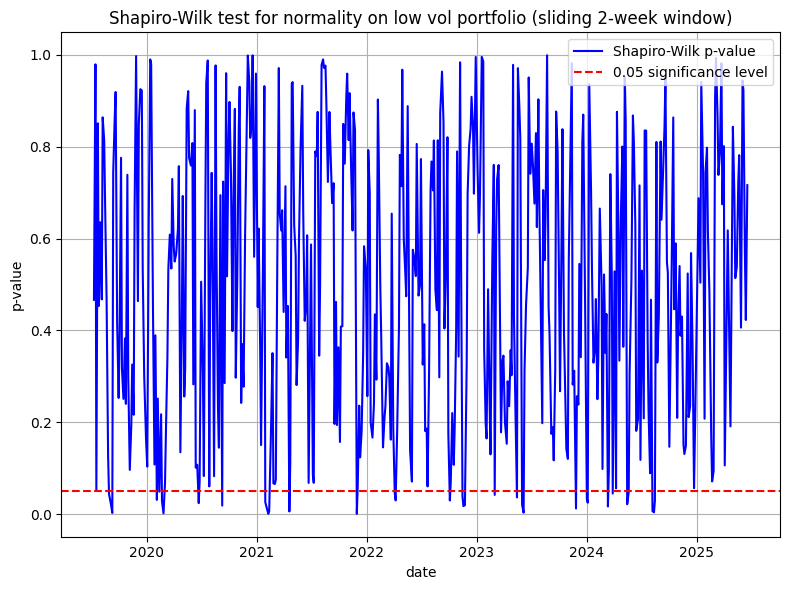

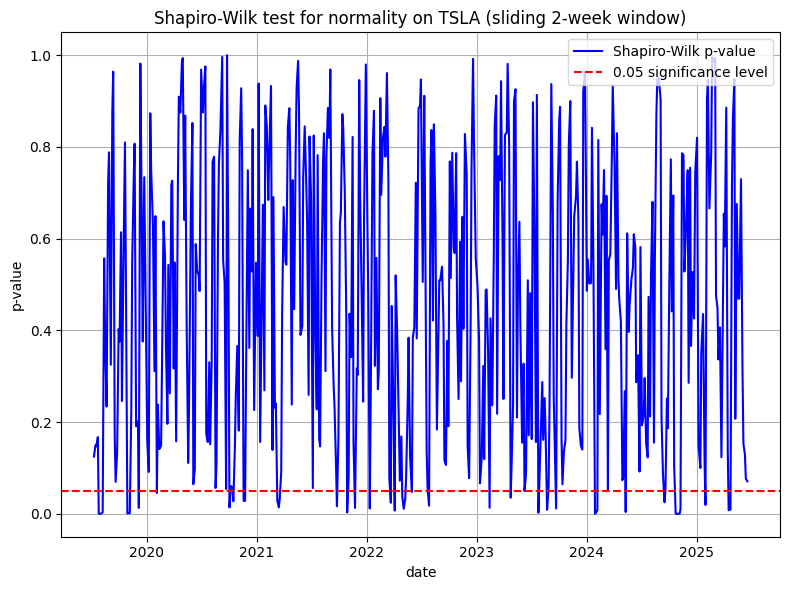

In [68]:
# and let's see 10-day sliding window

window_size = 10  # 2 weeks
step = 3  # 3-day stride

# low volatility portfolio

p_values = []

for i in range(window_size, len(portfolio_log_returns_6y), step):
    window_data = portfolio_log_returns_6y.iloc[i - window_size:i]
    stat, p = shapiro(window_data)
    p_values.append((portfolio_log_returns_6y.index[i], p))

p_df = pd.DataFrame(p_values, columns=["Date", "P_Value"]).set_index("Date")

plt.figure(figsize=(8,6))
plt.plot(p_df.index, p_df["P_Value"], label="Shapiro-Wilk p-value", color="blue")
plt.axhline(0.05, color="red", linestyle="--", label="0.05 significance level")
plt.title("Shapiro-Wilk test for normality on low vol portfolio (sliding 2-week window)")
plt.xlabel("date")
plt.ylabel("p-value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# tsla

p_values = []

for i in range(window_size, len(tsla_log_returns_6y), step):
    window_data = tsla_log_returns_6y.iloc[i - window_size:i]
    stat, p = shapiro(window_data)
    p_values.append((tsla_log_returns_6y.index[i], p))

p_df = pd.DataFrame(p_values, columns=["Date", "P_Value"]).set_index("Date")

plt.figure(figsize=(8,6))
plt.plot(p_df.index, p_df["P_Value"], label="Shapiro-Wilk p-value", color="blue")
plt.axhline(0.05, color="red", linestyle="--", label="0.05 significance level")
plt.title("Shapiro-Wilk test for normality on TSLA (sliding 2-week window)")
plt.xlabel("date")
plt.ylabel("p-value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The p-value behavior is even more extreme with smaller apparent "periods", with more windows passing the Shapiro-Wilk test with a p = 0.05 threshold.

**<font size="5">Project 3</font>** <br> <br>

The code below provides a visual representation of how the Black-Scholes call option price changes with respect to time.

a) Use the visualization to interpret how the rate of change of the Black-Scholes call option price behaves as time progresses.

b) Create a separate graphic to visualize how the rate of change of the Black-Scholes call option price depends on the spot price 
.

c) Repeat parts a and b for put option prices.

d) Make observations on the generated plots, regarding the following:
Call Option – Time Sensitivity,
Call Option – Spot Price Sensitivity,
Put Option – Time Sensitivity,
Put Option – Spot Price Sensitivity.

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import seaborn as sns
sns.set_style('darkgrid')

def bs_call(S0, K, sigma, t=1, r=0):
    """
    Description:
    
    Computes the Black-Scholes value of a European call option.
    
    Parameters:
        S0: Current asset price
        K: Strike price
        sigma: Yearly standard deviation of log-returns (volatility)
        t: Time to expiration (in years)
        r: Risk-free interest rate
    
    Returns:
        Call option price
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    #d2 = (np.log(S0/K) + (r-.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    return S0*norm.cdf(d1)-K*np.exp(-r*t)*norm.cdf(d2)

def bs_put(S0, K, sigma, t=1, r=0):
    """
    Description:
    
    Computes the Black-Scholes value of a European put option.
    
    Parameters:
        S0: Current asset price
        K: Strike price
        sigma: Yearly standard deviation of log-returns (volatility)
        t: Time to expiration (in years)
        r: Risk-free interest rate
    
    Returns:
        Put option price
    """
    
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    #d2 = (np.log(S0/K) + (r-.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    return -S0*norm.cdf(-d1)+K*np.exp(-r*t)*norm.cdf(-d2)





We will assume the risk-free rate is zero throughout for simplicity. Let's consider the Black-Scholes fair prices of call and put options for varying strike prices (above, below, and at the initial spot price).

First we look at strike price larger than spot price (OTM call, ITM put):

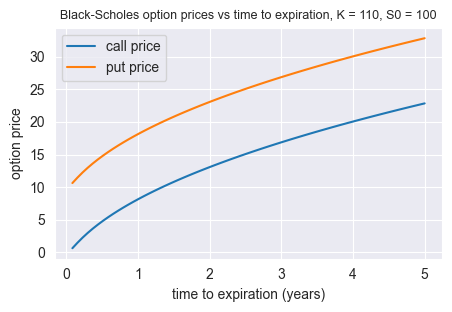

In [120]:
# out of the money call

S0 = 100
K = 110
sigma = .3
times = np.linspace(1/12, 5, 70)


call_prices = [bs_call(S0,K,sigma, t = times[i]) for i in range(len(times))]
put_prices = [bs_put(S0,K,sigma, t = times[i]) for i in range(len(times))]

plt.figure(figsize=(5, 3))
plt.title('Black-Scholes option prices vs time to expiration, K = 110, S0 = 100', fontsize=9)
plt.plot(times, call_prices, label='call price')
plt.plot(times, put_prices, label='put price')
plt.xlabel('time to expiration (years)')
plt.ylabel('option price')
plt.legend()
plt.grid(True)
plt.show()

As time to expiry gets closer to zero, we see that the call price goes to zero. This makes sense, as it is overwhelmingly more likely that the call option will end up being out of the money and there would be no point in exercising it (and hence purchasing it). Similarly, the put price approaches 10, which is the difference between the strike price and the spot price -- we expect the spot price to not change much, and hence we will exercise the put and collect the difference $K - S$.

Now let's consider $K < 100$, concretely $K = 90$, with spot still 100:

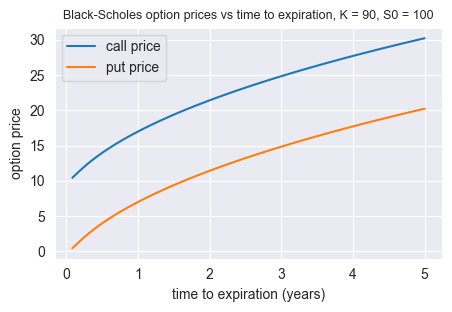

In [121]:
# in the money call

#S0 = 100
K = 90
#sigma = .3
#times = np.linspace(1/12, 5, 70)


call_prices = [bs_call(S0,K,sigma, t = times[i]) for i in range(len(times))]
put_prices = [bs_put(S0,K,sigma, t = times[i]) for i in range(len(times))]

plt.figure(figsize=(5, 3))
plt.title('Black-Scholes option prices vs time to expiration, K = 90, S0 = 100', fontsize=9)
plt.plot(times, call_prices, label='call price')
plt.plot(times, put_prices, label='put price')
plt.xlabel('time to expiration (years)')
plt.ylabel('option price')
plt.legend()
plt.grid(True)
plt.show()

Now the roles are reversed: if time to expiry is very small, we expect the put to expire worthless, and hence its price is close to 0. On the other hand, if $t$ is small, we expect exercising the call to ensure a profit of $S - K = 10$.

Finally, we look at the case of equal spot and strike:

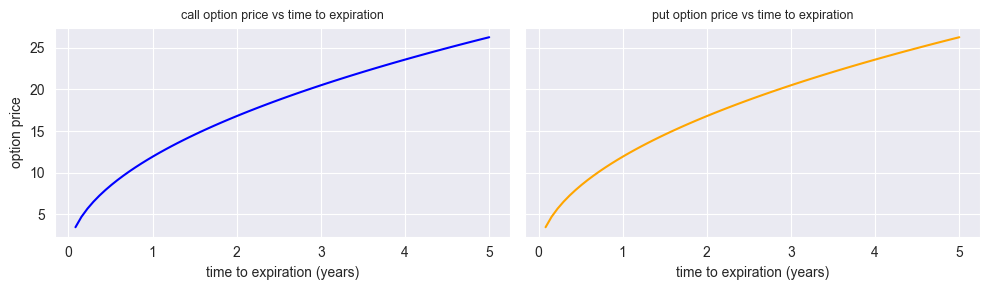

In [122]:
# at the money call

#S0 = 100
K = 100
#sigma = .3
#times = np.linspace(1/12, 5, 70)


call_prices = [bs_call(S0,K,sigma, t = times[i]) for i in range(len(times))]
put_prices = [bs_put(S0,K,sigma, t = times[i]) for i in range(len(times))]

# create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# left: call prices
axes[0].plot(times, call_prices, label='call price', color='blue')
axes[0].set_title('call option price vs time to expiration', fontsize=9)
axes[0].set_xlabel('time to expiration (years)')
axes[0].set_ylabel('option price')
axes[0].grid(True)

# right: put prices
axes[1].plot(times, put_prices, label='put price', color='orange')
axes[1].set_title('put option price vs time to expiration', fontsize=9)
axes[1].set_xlabel('time to expiration (years)')
axes[1].grid(True)

plt.tight_layout()
plt.show()


The graphs look identical, and this is no accident. We are assuming zero interest rate, so by call-put parity $C - P = S - K$, and since $S = K$, we get $C = P$ at all times.

What is not so clear from the graphs is that the option price tends to 0 as time to expiry approaches 0, which is what we theoretically expect. For example, we have:

In [123]:
print("Call price at t = 1/12:", call_prices[0])

Call price at t = 1/12: 3.4538621290854508


To verify that the price really does approach 0, let us zoom in our time interval to a small neighborhood of 0:

Call price at t = 1/12: 0.11968263923944278


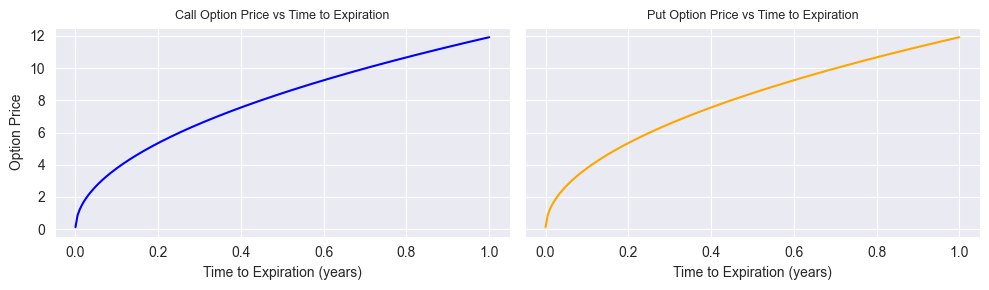

In [124]:
# zoom in closer to 0 to see how it approaches zero, though not as quickly as out of the money call

#S0 = 100
#K = 100
#sigma = .3
times = np.linspace(1/10000, 1, 200)


call_prices = [bs_call(S0,K,sigma, t = times[i]) for i in range(len(times))]
put_prices = [bs_put(S0,K,sigma, t = times[i]) for i in range(len(times))]

print("Call price at t = 1/12:", call_prices[0])


# create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# left: call prices
axes[0].plot(times, call_prices, label='Call Price', color='blue')
axes[0].set_title('Call Option Price vs Time to Expiration', fontsize=9)
axes[0].set_xlabel('Time to Expiration (years)')
axes[0].set_ylabel('Option Price')
axes[0].grid(True)

# right: put prices
axes[1].plot(times, put_prices, label='Put Price', color='orange')
axes[1].set_title('Put Option Price vs Time to Expiration', fontsize=9)
axes[1].set_xlabel('Time to Expiration (years)')
axes[1].grid(True)

plt.tight_layout()
plt.show()


The option price is approaching 0, but not as quickly as a deep OTM call or put. In all cases, the rate of change of the option price, with respect to time, decreases (to become more negative) as time to expiry approaches 0, with more dramatic deceleration when very close to 0.

Now let's look at the sensitivity of put and call prices to both time and spot price. First we look at calls:

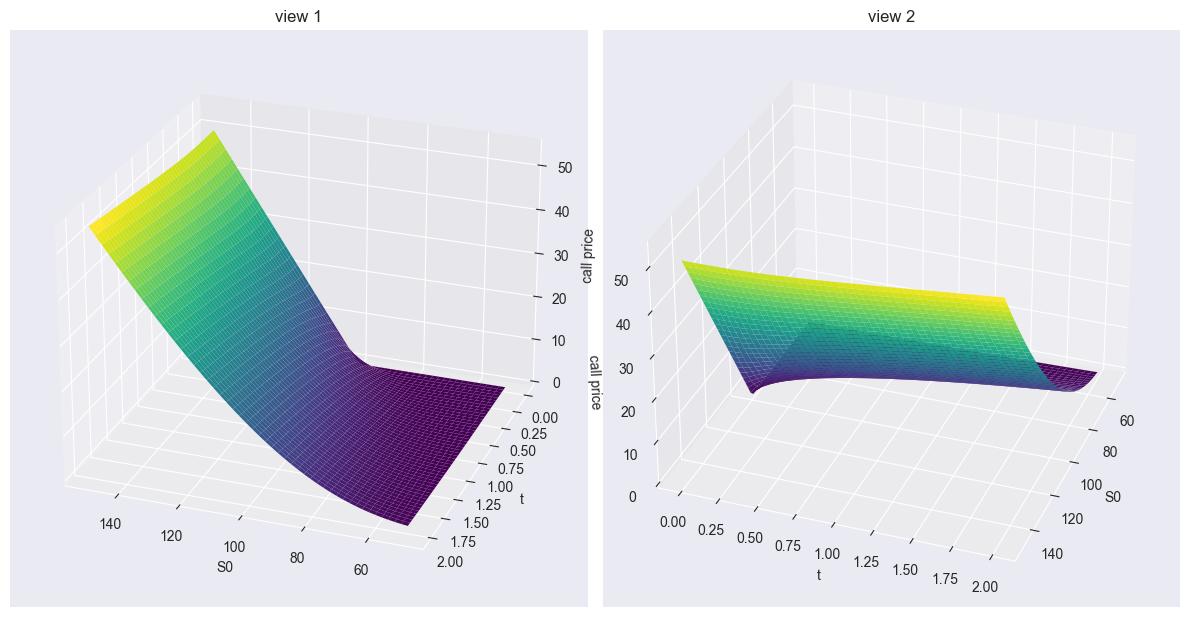

In [ ]:
# Call option price as function of t and S

K = 100
#sigma = 0.3
#r = 0.0

# range for spot prices and time
S_vals = np.linspace(50, 150, 50)
t_vals = np.linspace(1e-4, 2, 50)  # Avoid t=0 to prevent div/0

# create meshgrid and compute values
S_grid, T_grid = np.meshgrid(S_vals, t_vals)
grid = bs_call(S_grid, K, sigma, T_grid)
fig = plt.figure(figsize=(12,9))

# we plot two different views of the 3d graph

# left subplot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(S_grid, T_grid, grid, cmap='viridis', edgecolor='none')
ax1.set_title('view 1')
ax1.set_xlabel('S0')
ax1.set_ylabel('t')
ax1.set_zlabel('call price')
ax1.view_init(elev=25, azim=110)

# right subplot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(S_grid, T_grid, grid, cmap='viridis', edgecolor='none')
ax2.set_title('view 2')
ax2.set_xlabel('S0')
ax2.set_ylabel('t')
ax2.set_zlabel('call price')
ax2.view_init(elev=30, azim=20)

plt.tight_layout()
plt.show()


Note in the right-hand picture that we clearly see the 2d graph(s) from above at the bottom of the line of sight in the displayed surface. As time to expiry decreases, the value of an in the money call increases more rapidly as a function of spot price. Also, as time to expiry approaches 0, the price of the call remains very low for spot prices closer and closer to the strike price.

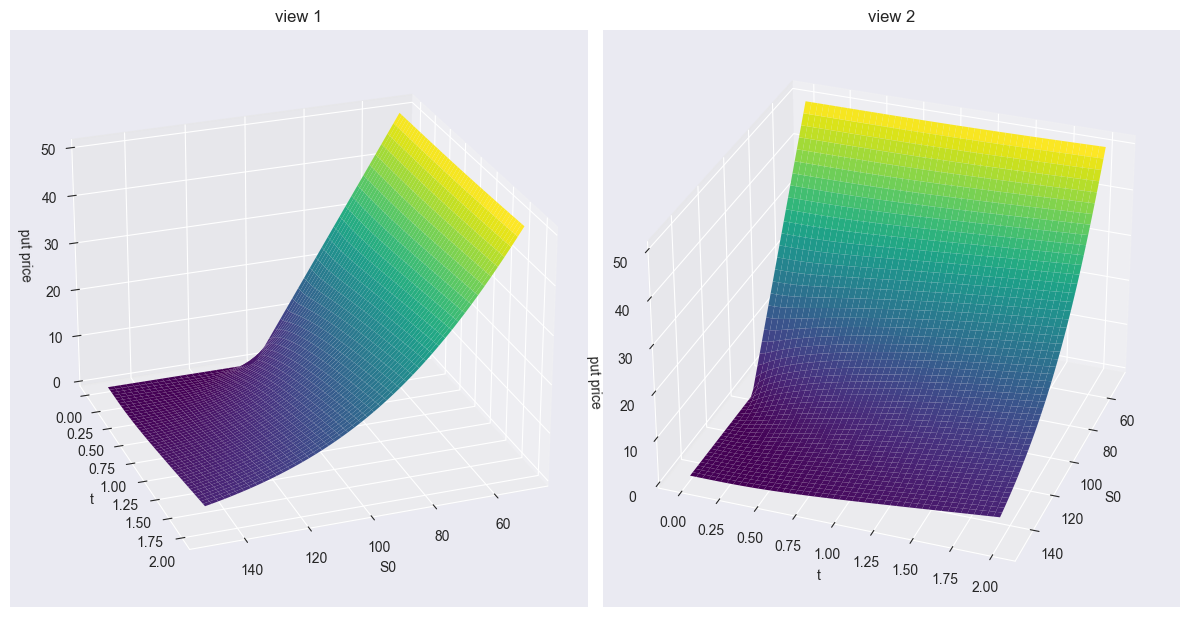

In [133]:
# Put option price as function of t and S

#K = 100
#sigma = 0.3
#r = 0.0

# range for spot prices and time
S_vals = np.linspace(50, 150, 50)
t_vals = np.linspace(1e-4, 2, 50)  # Avoid t=0 to prevent div/0

# create meshgrid and compute values
S_grid, T_grid = np.meshgrid(S_vals, t_vals)
grid = bs_put(S_grid, K, sigma, T_grid)
fig = plt.figure(figsize=(12,9))

# we plot two different views of the 3d graph

# left subplot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(S_grid, T_grid, grid, cmap='viridis', edgecolor='none')
ax1.set_title('view 1')
ax1.set_xlabel('S0')
ax1.set_ylabel('t')
ax1.set_zlabel('put price')
ax1.view_init(elev=25, azim=70)

# right subplot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(S_grid, T_grid, grid, cmap='viridis', edgecolor='none')
ax2.set_title('view 2')
ax2.set_xlabel('S0')
ax2.set_ylabel('t')
ax2.set_zlabel('put price')
ax2.view_init(elev=30, azim=20)

plt.tight_layout()
plt.show()


For fixed time to expiry very close to zero, the price of the put is very low for $S > K$, while when $S < K$, i.e. the put is in the money, the price increases rapidly as it goes deeper into the money. This rate of change with respect to $S$ (or rather, $-S$) is larger for these small times to expiry than it is for times to expiry further out.

Now let's consider the sensitivity of some partial derivatives of option prices (Greeks) with respect to spot price and time to expiry. We import the code from HW3 for delta (spot price partial derivative) and theta (time partial derivative):

In [134]:
def bs_call_delta(S0, K, sigma, t, r = 0):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)

def bs_put_delta(S0, K, sigma, t, r = 0):
    """
    Returns the Delta (sensitivity to spot price) of a European put option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Put Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1) - 1.

def bs_call_theta(S0,K,sigma,t,r = 0):
    """
    Returns the theta (rate of change with respect to time) of a European call option
    under Black-Scholes assumptions.
    
    
    To give daily theta, divide return by 252.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Theta of Call option
    """
    
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    return (-S0*norm.pdf(d1)*sigma)/(2*np.sqrt(t)) - r*K*np.exp(-r*t)*norm.cdf(d2)

def bs_put_theta(S0,K,sigma,t,r = 0):
    """
    Returns the theta (rate of change with respect to time) of a European put option
    under Black-Scholes assumptions.
    
    
    To give daily theta, divide return by 252.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Theta of Put option
    """
    
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    return (-S0*norm.pdf(d1)*sigma)/(2*np.sqrt(t)) + r*K*np.exp(-r*t)*norm.cdf(-d2)


We plot the value of call delta as a function of time to expiry (relatively close to 0) and spot price (around 100 strike):

In [ ]:
# range for spot prices and time
S_vals = np.linspace(50, 150, 100)
t_vals = np.linspace(1e-4, 2, 100)  # go closer to t = 0 than 1/12 to see more extreme behavior

# create meshgrid
S_grid, T_grid = np.meshgrid(S_vals, t_vals)

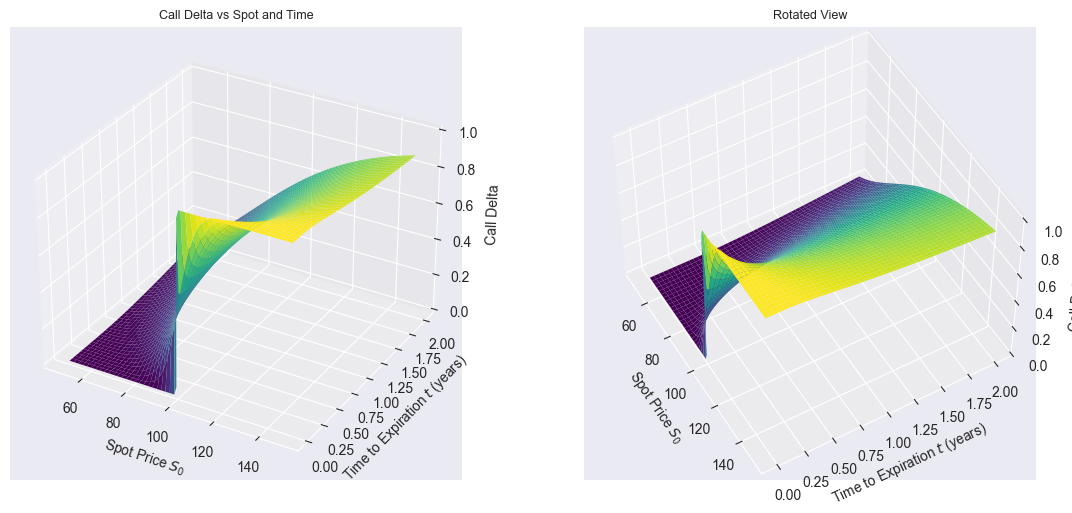

In [138]:
Delta_grid = bs_call_delta(S_grid, K, sigma, T_grid)


fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})

# left: first view
surf1 = axes[0].plot_surface(S_grid, T_grid, Delta_grid, cmap='viridis', edgecolor='none')
axes[0].set_title('Call Delta vs Spot and Time', fontsize=9)
axes[0].set_xlabel('Spot Price $S_0$')
axes[0].set_ylabel('Time to Expiration $t$ (years)')
axes[0].set_zlabel('Call Delta')

# right: second view
surf2 = axes[1].plot_surface(S_grid, T_grid, Delta_grid, cmap='viridis', edgecolor='none')
axes[1].view_init(elev=50, azim=-30)  # Rotate
axes[1].set_title('Rotated View', fontsize=9)
axes[1].set_xlabel('Spot Price $S_0$')
axes[1].set_ylabel('Time to Expiration $t$ (years)')
axes[1].set_zlabel('Call Delta')

plt.tight_layout()
plt.show()

Recall that the delta of a call is given by $\Phi(d_1)$, where $d_1 = \frac{ln(S_0/K)}{\sigma \sqrt{t}} + \tfrac{\sigma}{2} \sqrt{t}\,\,$ since $r = 0$. 

For fixed $S < K$, as $t \to 0$, the first term tends to $- \infty$ as the numerator is negative and the denominator tends to $0$ from the right. Hence $d_1 \to -\infty$ as $t \to 0$, and so $\Phi(d_1)$ decreases to 0 as $t$ decreases to 0.

For fixed $S = K$, we have $ln(S_0/K) = 0$ and so $d_1$ decreases to 0 as $t$ decreases to 0, and so $\Phi(d_1)$ decreases to $\tfrac{1}{2}$ as $t$ decreases to 0.

For fixed $S > K$, we have that $d_1 \to +\infty$ as $t$ decreases to 0, and so $\Phi(d_1)$ increases to $1$.

Now let us fix the time and look at spot price dependence. Since now $t$ is constant, we have that $d_1$ behaves, up to positive rescaling and a constant summand, like $ln(S_0)$. So, in particular, $d_1$ is an increasing function of $S_0$ which goes to $+\infty$ as $S_0$ goes to $+\infty$, and hence the call option delta $\Phi(d_1)$ is an increasing function of $S_0$, tending to $1$ as $S_0 \to +\infty$ and tending to $-1$ as $S_0 \to -\infty$.

These theoretical considerations are visible in the graphs above.

As for put option delta, from call-put parity $C - P = S - K$ we have $\Delta_P = \Delta_C - 1$, so the behavior of put delta is completely determined by the already analyzed behavior of call delta.

Now let's look at call theta as a function of time to expiry and spot price:

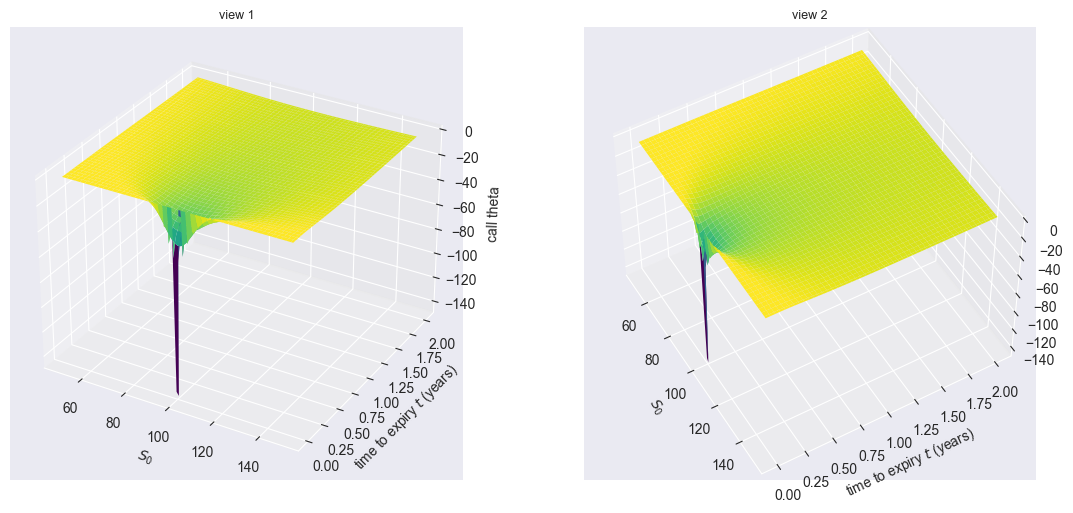

In [139]:
Theta_grid = bs_call_theta(S_grid, K, sigma, T_grid)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})

# left: view 1
surf1 = axes[0].plot_surface(S_grid, T_grid, Theta_grid, cmap='viridis', edgecolor='none')
axes[0].set_title('view 1', fontsize=9)
axes[0].set_xlabel('$S_0$')
axes[0].set_ylabel('time to expiry $t$ (years)')
axes[0].set_zlabel('call theta')

# right: view 2
surf2 = axes[1].plot_surface(S_grid, T_grid, Theta_grid, cmap='viridis', edgecolor='none')
axes[1].view_init(elev=50, azim=-30)  # Rotate
axes[1].set_title('view 2', fontsize=9)
axes[1].set_xlabel('$S_0$')
axes[1].set_ylabel('time to expiry $t$ (years)')

plt.tight_layout()
plt.show()

The feature of interest in this graph is the infinite-depth well forming as the spot price goes to the strike price of 100 and $t$ goes to 0. Theta decreases on all lines approaching this singular (100,0) point at the center of this well.

Recall that $\theta_C = \frac{-S_0 \varphi(d_1) \sigma}{2\sqrt{t}}$. Since $r = 0$, we have $d_1 = \frac{ln(S_0/K)}{\sigma \sqrt{t}} + \tfrac{\sigma}{2} \sqrt{t}$, and so in a neighborhood of $(S,t) = (100,0)$ the value of $d_1$ is bounded, and hence the value of $\varphi(d_1)$ is bounded. Hence, for fixed spot price, as $t \to 0$ we have that $\theta_C$ decreases to $-\infty$.

Furthermore, since $r = 0$, from call-put parity $C - P = S - K$ we have that $\theta_C = \theta_P$, so the graph for put theta is the same as above.

notes: theta -> -infty as expected from theta calculation (see paper). by call-put parity, r = 0 again, same for put so no need to plot. also put delta is determined by call delta. now just read off what we are seeing.